In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.pipeline import Pipeline

In [68]:
grid = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 14, 14, 10, 10, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 27, 27, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 14, 14, 14, 14, 10, 10, 10, 10],
    [0, 0, 0, 0, 0, 27, 27, 27, 27, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 14, 14, 14, 14, 10, 10, 10, 10],
    [0, 0, 0, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0, 0, 0,
        0, 0, 14, 14, 14, 14, 14, 14, 17, 17, 10, 10],
    [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0,
        0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 17, 17, 17],
    [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 5, 5, 14, 14,
        14, 14, 14, 14, 14, 14, 2, 2, 18, 18, 18, 0, 0],
    [27, 27, 27, 27, 27, 27, 27, 27, 27, 20, 20, 5, 5,
        5, 5, 14, 14, 24, 24, 2, 2, 2, 2, 18, 0, 0, 0],
    [0, 27, 27, 27, 27, 26, 26, 26, 20, 20, 20, 20, 20,
        20, 5, 5, 19, 21, 24, 24, 22, 22, 22, 22, 0, 0, 0],
    [0, 26, 26, 26, 26, 26, 26, 26, 20, 20, 20, 20, 20,
        5, 5, 5, 21, 21, 11, 11, 11, 1, 1, 15, 0, 0, 0],
    [0, 26, 26, 26, 26, 26, 26, 26, 26, 26, 20, 20, 20,
        20, 5, 21, 21, 25, 12, 12, 11, 16, 1, 15, 0, 0, 0],
    [0, 0, 0, 26, 26, 26, 26, 26, 26, 26, 26, 20, 20, 20,
        25, 25, 25, 25, 12, 12, 12, 16, 23, 23, 0, 0, 0],
    [0, 0, 0, 0, 26, 26, 26, 26, 26, 26, 26, 25, 25, 25,
        25, 3, 3, 8, 13, 13, 16, 16, 4, 23, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 28, 25, 25,
        25, 8, 8, 8, 13, 13, 13, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 28, 25, 28,
        28, 28, 7, 7, 7, 7, 6, 6, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 28, 28,
        28, 7, 7, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]
])
days = 8*7
prediction_days=2*7
infected = pd.read_csv('data/time_series_covid19_confirmed_global.csv', usecols=range(4+days+prediction_days))
recovered = pd.read_csv('data/time_series_covid19_recovered_global.csv', usecols=range(4+days+prediction_days))
deceased = pd.read_csv('data/time_series_covid19_deaths_global.csv', usecols=range(4+days+prediction_days))
infected = infected[infected['Country/Region'] == 'China']
recovered = recovered[recovered['Country/Region'] == 'China']
deceased = deceased[deceased['Country/Region'] == 'China']

final_df = infected.copy()
final_df.iloc[:, 4:] = infected.iloc[:, 4:].values - recovered.iloc[:, 4:].values - deceased.iloc[:, 4:].values

fixed_columns = final_df.iloc[:, :4]
variable_columns = final_df.iloc[:, 4:]

train_infected=pd.concat([fixed_columns, variable_columns.iloc[:, :(days)]], axis=1)
test_infected=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)
regions = pd.read_csv('data/regions.csv')
alpha, beta, gamma = 0.21, 1.4, 1/5.1

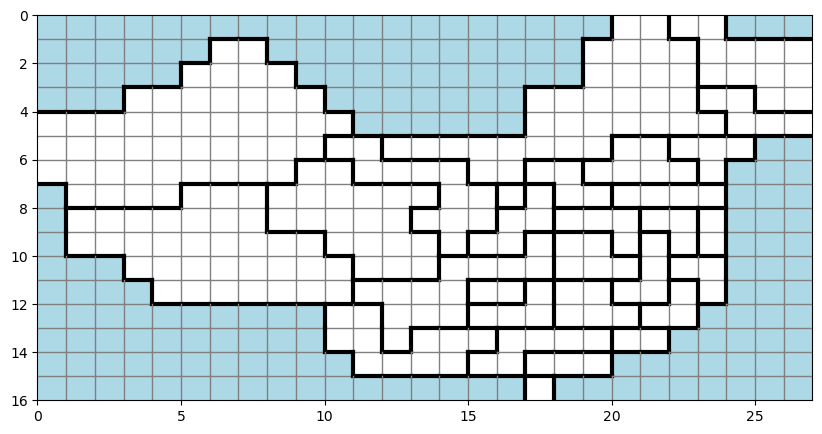

In [69]:
df = pd.DataFrame(grid)

cmap = sns.diverging_palette(0, 250, as_cmap=True)
color_map = cmap.from_list("", [(0, "lightblue"), (1, "white")], N=2)

f, ax = plt.subplots(figsize=(10, 5))
plt.pcolormesh(df, cmap=color_map, vmin=0, vmax=1)

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if j < df.shape[1] - 1 and df.iloc[i, j] != df.iloc[i, j + 1]:
            plt.plot([j + 1, j + 1], [i, i + 1], color="black", linewidth=3)
        elif j < df.shape[1] - 1:
            plt.plot([j + 1, j + 1], [i, i + 1], color="gray", linewidth=1)
        if i < df.shape[0] - 1 and df.iloc[i, j] != df.iloc[i + 1, j]:
            plt.plot([j, j + 1], [i + 1, i + 1], color="black", linewidth=3)
        elif i < df.shape[0] - 1:
            plt.plot([j, j + 1], [i + 1, i + 1], color="gray", linewidth=1)

plt.gca().invert_yaxis()
# Show the plot
plt.show()

In [70]:
def calculate_ca(days,grid,data):
    ca = np.zeros((days, grid.shape[0], grid.shape[1]))
    region_population = regions[['ID', 'Cell Count']].set_index('ID').to_dict()[
        'Cell Count']
    for i in range(days):
        col_name = data.columns[i+4]
        region_cases = data[['Province/State', col_name]
                                ].set_index('Province/State').to_dict()[col_name]
        for j in range(grid.shape[0]):
            for k in range(grid.shape[1]):
                if grid[j, k] != 0:
                    region_id = grid[j, k]
                    cell_count = region_population[region_id]
                    region_name = regions.loc[regions['ID']
                                              == region_id, 'Region'].iloc[0]
                    cases = 0
                    if ',' in region_name:
                        region_list = region_name.split(',')
                        for sub_region in region_list:
                            sub_region = sub_region.strip()
                            cases += region_cases.get(sub_region, 0)
                    else:
                        cases = region_cases.get(region_name, 0)
                    ca[i, j, k] = cases / cell_count
    return ca

def fix_p(p):
    one,center,north,east,south,west=range(6)
    rows, cols = p.shape[0], p.shape[1]
    for i in range(rows):
        for j in range(cols):
            if grid[i,j] == 0:
                p[i,j] = 0
            else:
                if i == 0:
                    p[i,j,north] = 0
                elif i == rows - 1:
                    p[i,j,south] = 0
                if j == 0:
                    p[i,j,west] = 0
                elif j == cols - 1:
                    p[i,j,east] = 0
                if i > 0 and grid[i-1,j] == 0:
                    p[i,j,north] = 0
                if j < cols - 1 and grid[i,j+1] == 0:
                    p[i,j,east] = 0
                if i < rows - 1 and grid[i+1,j] == 0:
                    p[i,j,south] = 0
                if j > 0 and grid[i,j-1] == 0:
                    p[i,j,west] = 0
    return p



In [172]:
ca_infected = calculate_ca(days,grid,train_infected)

delta_I = np.diff(ca_infected, axis=0)

p = np.zeros((len(ca_infected) - 1, grid.shape[0], grid.shape[1], 6))
for i in range(1, len(ca_infected)):
    current_day = ca_infected[i - 1]
    north = np.zeros_like(current_day)
    north[1:] = current_day[:-1]
    south = np.zeros_like(current_day)
    south[:-1] = current_day[1:]
    east = np.zeros_like(current_day)
    east[:, :-1] = current_day[:, 1:]
    west = np.zeros_like(current_day)
    west[:, 1:] = current_day[:, :-1]
    current_cell = np.stack(
        [np.ones_like(current_day), current_day, north, east, south, west], axis=-1)
    p[i - 1] = np.concatenate((current_cell[..., :1],
                              current_cell[..., 1:] * (beta - gamma - alpha)), axis=-1)
for i in range(p.shape[0]):
    p[i]=fix_p(p[i])

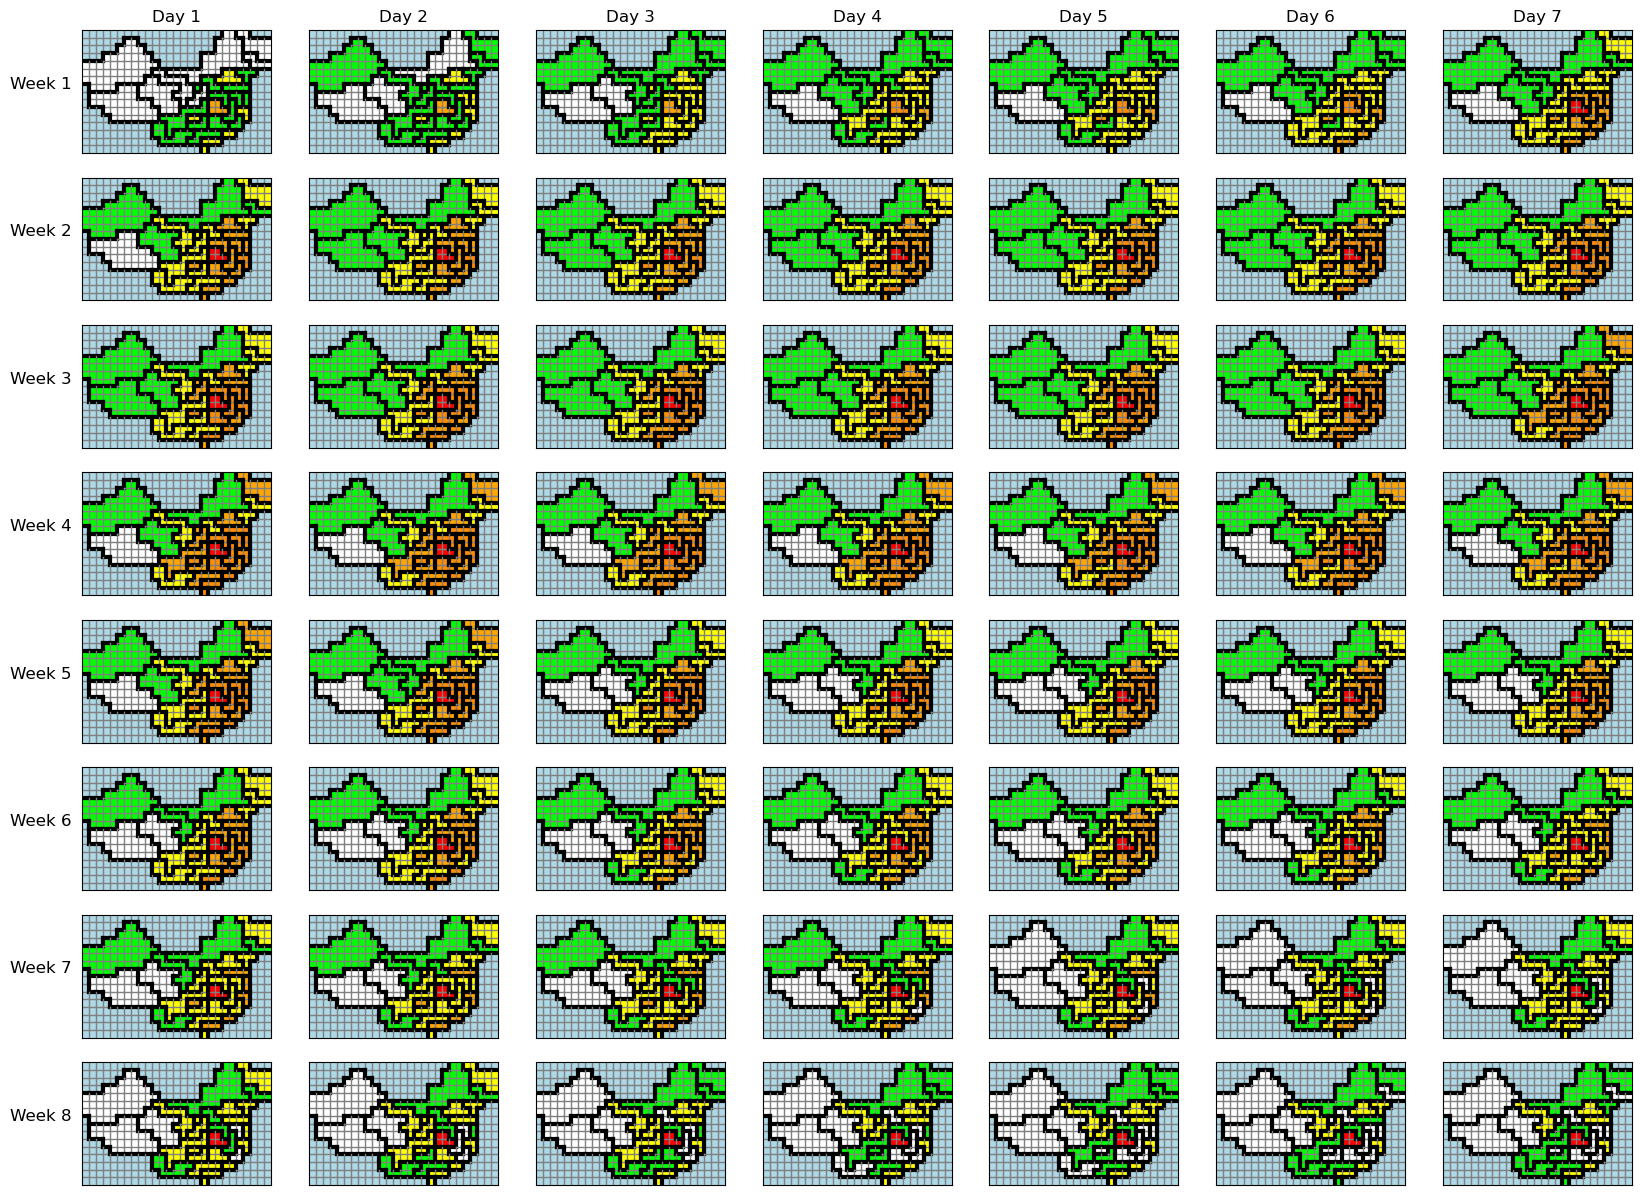

In [236]:
color_grid=ca_infected
for i in range(days):
    aux=color_grid[i]
    aux[np.where(grid==0)]=-2
    color_grid[i]=aux
boundaries = [-2,-1, 0.02127659574468084, 2, 25, 100, 500, 501]
values = ['lightblue', 'white', 'lime', 'yellow', 'orange', 'darkorange', 'red']
cmap = plt.matplotlib.colors.ListedColormap(values)


norm = plt.matplotlib.colors.BoundaryNorm(boundaries, cmap.N)

fig, axs = plt.subplots(8, 7, figsize=(20, 15), sharex=True, sharey=True)

cols=['Day {}'.format(day+1) for day in range(7)]
rows=['Week {}'.format(week+1) for week in range(8)]

for i, ax in enumerate(axs.flatten()):
    if i < 56:
        ax.pcolormesh(color_grid[i, :, :], cmap=cmap, norm=norm, shading='flat')
        ax.set_ylim(color_grid[i, :, :].shape[0], 0)
        n, m = grid.shape
        for j in range(n):
            for k in range(m):
                if k < m - 1 and grid[j, k] != grid[ j, k + 1]:
                    ax.plot([k + 1, k + 1], [j, j + 1], color="black", linewidth=3)
                elif k < m - 1:
                    ax.plot([k + 1, k + 1], [j, j + 1], color="gray", linewidth=1)
                if j < n - 1 and grid[ j, k] != grid[ j + 1, k]:
                    ax.plot([k, k + 1], [j + 1, j + 1], color="black", linewidth=3)
                elif j < n - 1:
                    ax.plot([k, k + 1], [j + 1, j + 1], color="gray", linewidth=1)
    else:
        ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

for ax, col in zip(axs[0],cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0],rows):
    ax.set_ylabel(row,rotation=0,size='large',ha='right')
plt.show()

In [ ]:
def predict_i(p, q):
    N, M, _ = p.shape
    delta_i = np.zeros((N, M))
    for j in range(N):
        for k in range(M):
            delta_i[j, k] = np.dot(p[j, k], q[j, k])
    return delta_i

def find_q(delta_i, p):
    t, N, M = delta_i.shape
    q = np.zeros((N, M, 6))
    for j in range(N):
        for k in range(M):
            if grid[j,k]!=0:
                delta_i_jk = delta_I[:,j,k]
                p_jk = p[:,j,k,:]
                model = sklearn.linear_model.Ridge().fit(p_jk, delta_i_jk)
                q[j, k, :] = model.coef_
                q[j,k,0]=model.intercept_
    return q

In [173]:
q = find_q(delta_I, p)

In [182]:
def calculate_p(alpha,beta,gamma,m_bar):
    north = np.zeros_like(m_bar)
    north[1:] = m_bar[:-1]
    south = np.zeros_like(m_bar)
    south[:-1] = m_bar[1:]
    east = np.zeros_like(m_bar)
    east[:, :-1] = m_bar[:, 1:]
    west = np.zeros_like(m_bar)
    west[:, 1:] = m_bar[:, :-1]
    aux = np.stack(
        [np.ones_like(m_bar), m_bar, north, east, south, west], axis=-1)
    new_p = np.concatenate((aux[..., :1],
                              aux[..., 1:] * (beta - gamma - alpha)), axis=-1)
    return fix_p(new_p)
import math
def calculate_m_bar(m):
    unique_values = np.unique(grid)
    m_bar = np.zeros_like(m)
    for value in unique_values:
        indices = np.where(grid == value)
        cell_count = len(indices[0])
        m_sum = math.ceil(np.sum(m[indices]))
        m_bar[grid == value] = m_sum / cell_count
    return m_bar

def calculate_m(m_bar,p_bar,q):
    return m_bar+predict_i(p_bar,q)

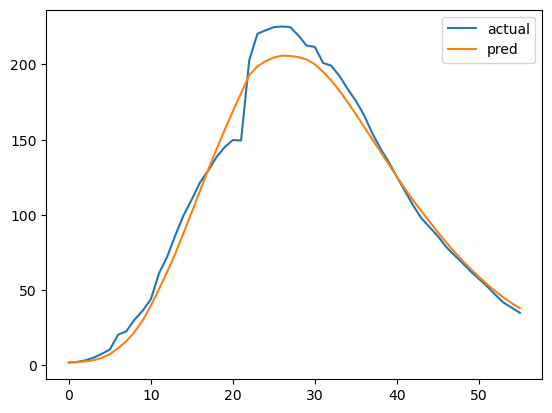

In [186]:
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
prediction[0]=m
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    m=calculate_m(m_bar,p[i-1],q)
    prediction[i]=m
    
sums=[ca_infected[i].sum()/258 for i in range(days)]
pred_sums=[prediction[i].sum()/258 for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

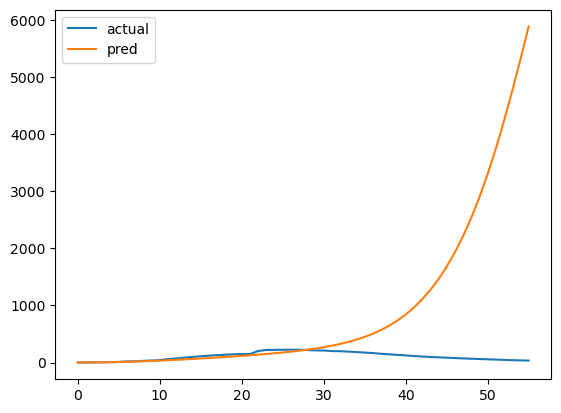

In [184]:
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
prediction[0]=m
p_bar=p[0]
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    p_bar=calculate_p(alpha,beta,gamma,m_bar)
    m=calculate_m(m_bar,p_bar,q)
    prediction[i]=m
    
sums=[ca_infected[i].sum()/258 for i in range(days)]
pred_sums=[prediction[i].sum()/258 for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

In [170]:
actual=calculate_ca(prediction_days,grid,test_infected)
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))
m=actual[0]
prediction[0]=m
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    p_bar=calculate_p(alpha,beta,gamma,m_bar)
    m=calculate_m(m_bar,p_bar,q)
    print("Pred:",m.sum())
    print("Actual:",actual[i].sum())
    prediction[i]=m

Pred: 7356.862621007124
Actual: 7372.0
Pred: 6777.680245386314
Actual: 6731.0
Pred: 6368.687224229585
Actual: 6189.0
Pred: 6126.5179825547775
Actual: 5799.000000000001
Pred: 6045.484535746245
Actual: 5405.0
Pred: 6118.681735087292
Actual: 5026.0
Pred: 6338.923515301345
Actual: 4599.999999999999
Pred: 6699.519285186246
Actual: 4309.0
Pred: 7194.905024065124
Actual: 3856.0000000000005
Pred: 7821.147923571933
Actual: 3565.0
Pred: 8576.346321038998
Actual: 3172.0000000000005
Pred: 9460.948251400665
Actual: 2908.0
Pred: 10478.012383147076
Actual: 2730.0000000000005


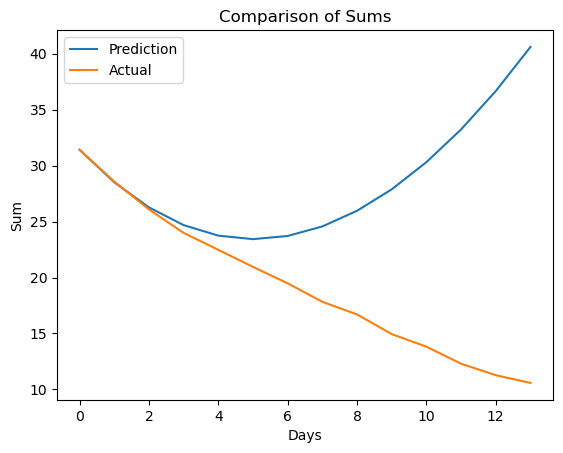

In [171]:
prediction_sums = [prediction[i].sum()/258 for i in range(prediction_days)]
actual_sums = [actual[i].sum()/258 for i in range(prediction_days)]

plt.plot(range(prediction_days), prediction_sums, label="Prediction")
plt.plot(range(prediction_days), actual_sums, label="Actual")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sum")
plt.title("Comparison of Sums")
plt.show()